In [87]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import os
#from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
from moviepy.editor import VideoFileClip

In [88]:
# Calibrate camera with chessboard figures
def calibrate_camera():
# Read in images and find grid points
    objpoints = []
    imgpoints = []
    nx = 9 # number of inside corners in x
    ny = 6 # number of inside corners in y
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinate
    path ='../camera_cal/calibration*.jpg' # list out all camera calibration images in the folder
    fnames = glob.glob(path)
    for idx, fname in enumerate(fnames):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #convert to grayscale
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)# Find the chess borard corners
        # if found, draw corners
        if ret == True:
            # Draw and display corners
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            #plt.imshow(img)
    #calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    
    return mtx, dist

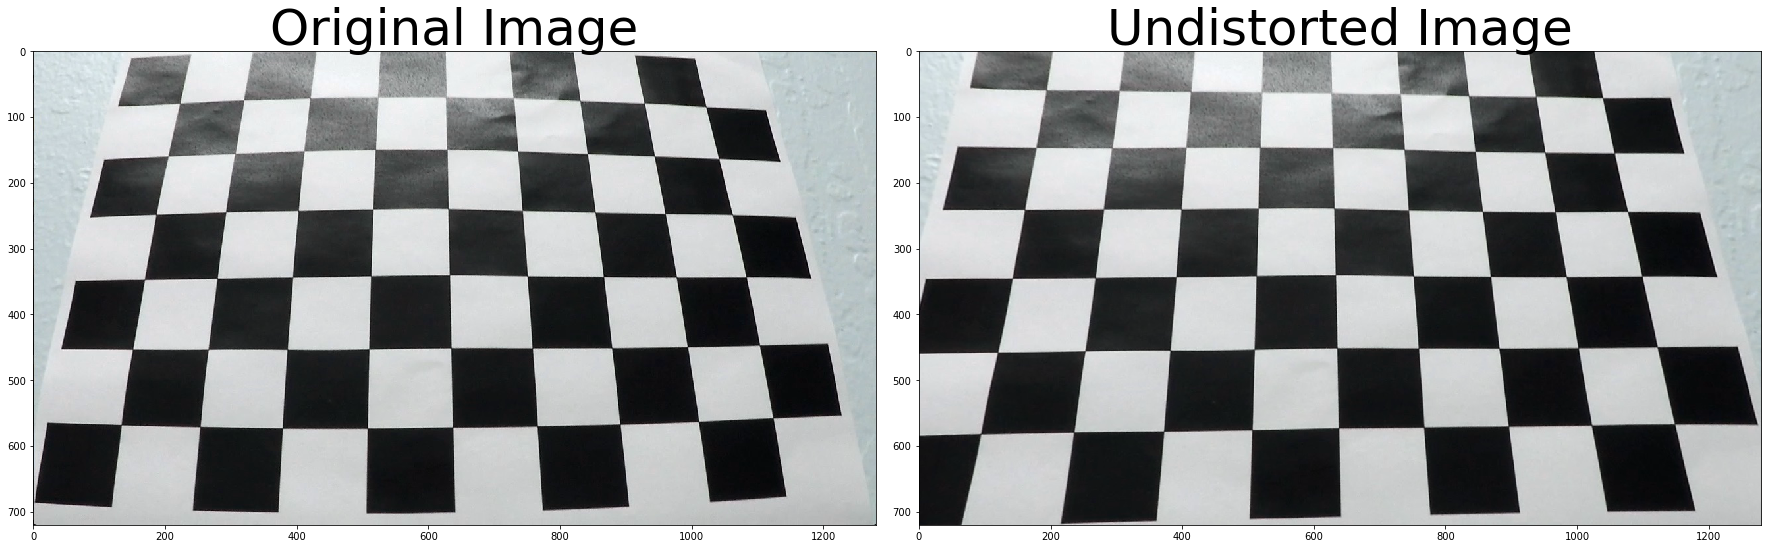

In [89]:
# Test calibrate_camera function

mtx, dist = calibrate_camera() # 
path ='../camera_cal/calibration*.jpg' # list out all camera calibration images in the folder
fnames = glob.glob(path)
img = cv2.imread(fnames[1])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    # 2) Take the absolute value of the derivative or gradient
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    abs_mask = np.zeros_like(scaled_sobel)
    abs_mask [(scaled_sobel>=thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 5) Return this mask as your binary_output image

    return abs_mask


In [5]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 4) Create a binary mask where mag thresholds are met
    # 5) Return this mask as your binary_output image
    mag_mask = np.zeros_like(gradmag)
    mag_mask[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_mask

In [6]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    # 2) Take the absolute value of the x and y gradients
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 4) Create a binary mask where direction thresholds are met
    dir_mask = np.zeros_like (absgraddir)
    dir_mask[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return dir_mask

In [7]:
# locate lanes based on directional gradient, x-axis gradient and color thresholds
def filtered_img(img, s_thresh=(120, 255), sx_thresh=(20, 200), dir_thresh = (np.pi/6,np.pi/2), c_thresh = 150):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Sobel x
    sobelx = abs_sobel_thresh(gray,'x',sx_thresh[0],sx_thresh[1])
    # Threshold direction
    dir_mask = dir_threshold(gray,3,dir_thresh)
    
    # Combine directional and sobel x thresholds
    combined_grad = ((sobelx == 1) & (dir_mask == 1))
    
    # Threshold color channel RGB
    R = img[:,:,0];
    G = img[:,:,1]
    r_g = np.zeros_like(R)
    r_g = (R>c_thresh) & (G>c_thresh)
    
    # Threshold color channel HLS
    s_mask = (s_channel>s_thresh[0])&(s_channel<s_thresh[1]) # detect bright yellow and white lane
    l_mask = (l_channel>s_thresh[0])&(l_channel<s_thresh[1]) # detect shadow areas
    
    #Combine all thresholds
    combined_all = np.zeros_like(R)
    combined_all [(r_g & l_mask) & (s_mask | combined_grad)]= 1
    
    # apply the mask of interested region
    region_mask = np.zeros_like(combined_all)
    h, w = img.shape[0], img.shape[1]
    polygon_vertice = np.array([[0,h-1], [w//2, h//2], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(region_mask,[polygon_vertice],1)
    
    filtered_image = cv2.bitwise_and(combined_all,region_mask)
    
    return filtered_image

    

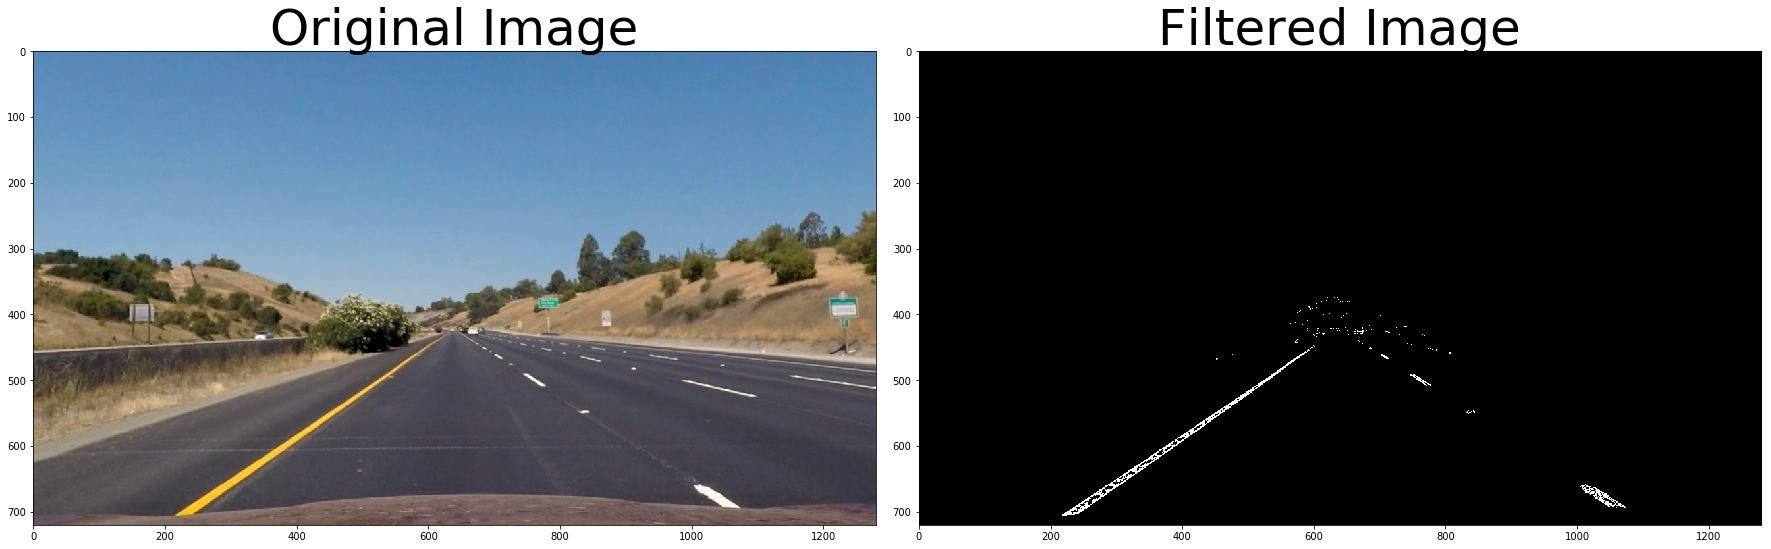

In [72]:
# Example of filtered image

img = mpimg.imread('../test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)

filtered_image = filtered_img(img)
cv2.imwrite('filtered_image.jpg',filtered_image)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(filtered_image, cmap='gray')
ax2.set_title('Filtered Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
# Perspective Transform
def perspective_transform():
    # Populate the transformation matrix
    src = np.float32([(220,720), (1110, 720), (570, 470), (722, 470)])  # Manually get these numbers from plot
    dst = np.float32([[320, 720], [920, 720], [320, 1], [920, 1]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

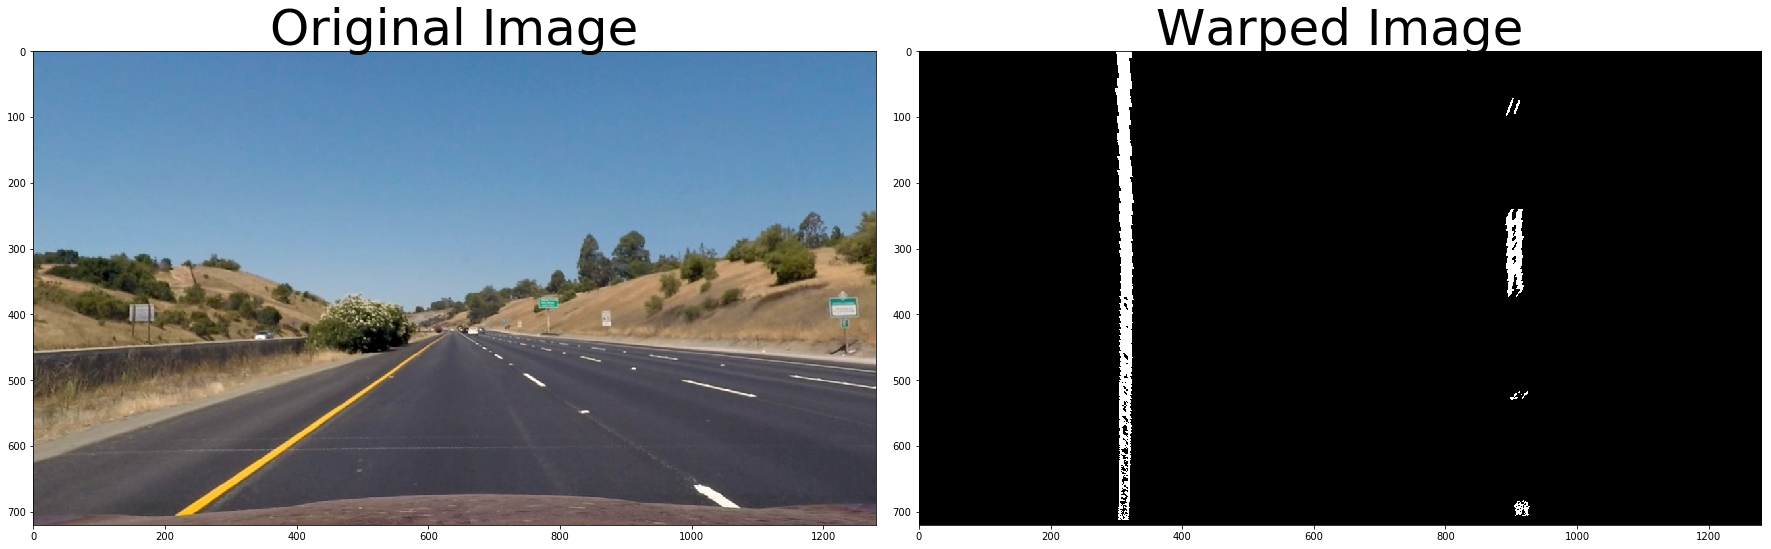

In [10]:
M, Minv = perspective_transform()
copy = img.copy()
warped = cv2.warpPerspective(filtered_image, M, (img.shape[1], img.shape[0]) , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [34]:
# Use sliding window to find the lanes
# This function applies to the case where lanes are not found in the previous frame
def find_lane_sliding_window(warped_img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_img.shape[0]//nwindows)  
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_img.shape[0] - (window+1)*window_height
        win_y_high = warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
#         print([win_xleft_low,win_y_low,win_xleft_high,win_y_high])
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
#         plt.figure()
#         plt.imshow(out_img)
#         print('window = ',window)
#         print('win_xleft_low =',win_xleft_low,'win_y_low =',win_y_low)
#         print('win_xleft_high =',win_xleft_high,'win_y_high =',win_y_high)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#             win_xleft_low = leftx_current - margin
#             win_xleft_high = leftx_current + margin
#             cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), [0,0,255],2)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

    

In [35]:
# fit quadratic equation to detected lane pixels
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty


(720, 0)

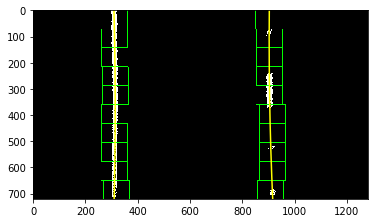

In [36]:
leftx, lefty, rightx, righty, out_img = find_lane_sliding_window(warped)
plt.imshow(out_img)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly((warped.shape[0], warped.shape[1]), leftx, lefty, rightx, righty)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

In [40]:
# If lane is detected on the previous frame, search around it on the current frame

def find_lane_from_prior(warped_img, left_fit, right_fit, ploty):
    """
    Given the lane from previous frame, find the lane in the current frame
    """
    margin = 100

    # Grab activated pixels
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(warped_img.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    left_lane = np.array(list(zip(left_fitx, ploty)), np.int32)
    right_lane = np.array(list(zip(right_fitx, ploty)), np.int32)
    result = cv2.polylines(result, [left_lane], False, (0,255,255), 4)
    result = cv2.polylines(result, [right_lane], False, (0,255,255), 4)
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, result


(720, 0)

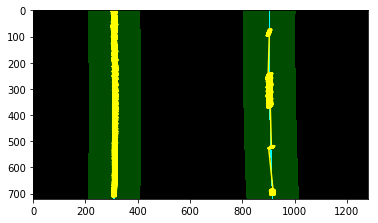

In [42]:
leftx, lefty, rightx, righty, result = find_lane_from_prior(warped, left_fit, right_fit, ploty)
plt.imshow(result)
plt.plot(leftx, lefty, color='yellow')
plt.plot(rightx, righty, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

In [43]:
# Compute the radius of curvature and center offset

def curvature_and_position(ploty, left_fit, right_fit, img_w):
    """
    Compute the curvature of lane at the bottom and
    find the position of car relative to the center line
    """
    # Define y-value of interest
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define some constants
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Compute curvature
    left_fit[0] = left_fit[0]*xm_per_pix/(ym_per_pix**2)
    left_fit[1] = left_fit[1]*xm_per_pix/ym_per_pix
    right_fit[0] = right_fit[0]*xm_per_pix/(ym_per_pix**2)
    right_fit[1] = right_fit[1]*xm_per_pix/ym_per_pix
    left_curverad = np.power(1+(2*left_fit[0]*y_eval+left_fit[1])**2, 3/2)/np.abs(2*left_fit[0])
    right_curverad = np.power(1+(2*right_fit[0]*y_eval+right_fit[1])**2, 3/2)/np.abs(2*right_fit[0])
    aver_curverad = 0.5*(left_curverad + right_curverad)

    # Compute the relative position
    x_left = left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2]
    x_right = right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2]

    car_pos = img_w // 2
    center_line = (x_left + x_right) // 2
    
    distance = (car_pos - center_line)*xm_per_pix
    
    # Return the left/right curvature and the distance to the center line (right is positive)
    return aver_curverad, distance

In [54]:
curvature, distance = curvature_and_position(ploty, left_fit, right_fit , warped.shape[1])
print('curvature = ',curvature,' distance = ',distance)

curvature =  2688.81688484  distance =  0.0264285714286


In [80]:
# Inverse Transform
def draw_lane_on_img(undist, warped, left_fitx, right_fitx, ploty, Minv, curvature, distance):
    """
    Draw the left/right lane back to the original image
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Draw lane boundary
    left_lane = np.int32(pts_left)
    right_lane = np.int32(pts_right)
    color_warp = cv2.polylines(color_warp, [left_lane], False, (255,0,0), 16)
    color_warp = cv2.polylines(color_warp, [right_lane], False, (0, 0, 255), 16)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.4, 0)

    # Write out the curvature and relative position
    curv_info = "Radius of Curvature ={0:.2f}(m).".format(curvature)
    if distance > 0:
        pos_info = " Car is {0:.2f}m right of center.".format(distance)
    else:
        pos_info = " Car is {0:.2f}m left of center.".format(-distance)
    info = curv_info + pos_info
    cv2.putText(result, info, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, bottomLeftOrigin=False)

    return result

def process_img(img, mtx, dist, line):
    """
    Given the original image, camera calibration properties, draw the lane lines
    on the original image and return the image
    The line class is updated on the fly.
    """
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    binary_img = filtered_img(img)
    M, Minv = perspective_transform()
    warped = cv2.warpPerspective(binary_img, M, (img.shape[1], img.shape[0]))
    warped *= 255

    # Use line.fine_lane method to find the lane
    left_fitx, right_fitx, ploty, curvature, distance = line.find_lane(warped)
#     import pdb;pdb.set_trace()
    # Draw lanes and return it
    out_img = draw_lane_on_img(img, warped, left_fitx, right_fitx, ploty, Minv, curvature, distance)
    return out_img

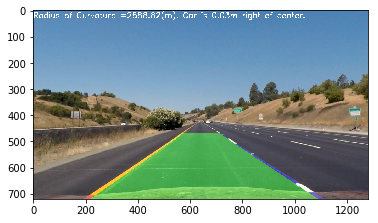

In [64]:
result = draw_lane_on_img(img, warped, left_fitx, right_fitx, ploty, Minv, curvature, distance);
plt.imshow(result)

In [78]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # poly fit from previous frame
        self.last_left_fit = None
        self.last_right_fit = None

        # Tolerance and number of frame to average
        self.tol_dist = 4
        
    def find_lane(self, warped_img):
#     Find the lane in image
#     The lane is rejected if it is rapidly changed from previous frame;
#     otherwise it is averaged in the latest n frames
    
        if not self.detected:
            # Use sliding window if lanes are not detected on the previous frame
            leftx, lefty, rightx, righty, out_img = leftx, lefty, rightx, righty, out_img = find_lane_sliding_window(warped_img)
            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(warped_img.shape, leftx, lefty, rightx, righty)
            curvature, distance = curvature_and_position(ploty, left_fit, right_fit, warped_img.shape[1])
            self.last_left_fit = left_fit
            self.last_right_fit = right_fit
            self.last_ploty = ploty
            self.detected = True
            return left_fitx, right_fitx, ploty, curvature, distance

        else:
            try:
                leftx, lefty, rightx, righty, out_img = find_lane_from_prior(warped_img, self.last_left_fit, self.last_right_fit, self.ploty)
                left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(warped_img.shape, leftx, lefty, rightx, righty)
                curvature, distance = curvature_and_position(ploty, left_fit, right_fit, warped_img.shape[1])

                # If the distance doesn't make sense, use sliding window to search again
                if abs(distance) > self.tol_dist:
                    self.detected = False
                    return self.find_lane(warped_img)
                else:
                    self.last_left_fit = left_fit
                    self.last_right_fit = right_fit
                    self.last_ploty = ploty
                    self.detected = True
                    return left_fitx, right_fitx, ploty, curvature, distance
            except:
                # Exception raised by fitpoly when left/right is empty
                self.detected = False
                return self.find_lane(warped_img)

In [86]:
#Main Function
def process_all_images(path=r'../test_images'):
    # Iterate through all files
    for filename in os.listdir(path):
        print(filename)
        mtx, dist = calibrate_camera()
        path_to_image = os.path.join(path, filename)
        img = mpimg.imread(path_to_image)
        new_img = process_img(img, mtx, dist, Line())
#         plt.figure()
#         plt.imshow(new_img)
        
        new_filename = os.path.splitext(filename)[0] + "_output.jpg"
        new_filename = os.path.join('../output_images', new_filename)
        mpimg.imsave(new_filename, new_img)

def process_videos(path_to_video, path_to_output):
    # Create a wrapper on process_img function
    mtx, dist = calibrate_camera()
    line = Line()
    
    def process_video_frame(img):
        return process_img(img, mtx, dist, line)
    
    clip = VideoFileClip(path_to_video)
    new_clip = clip.fl_image(process_video_frame)
    new_clip.write_videofile(path_to_output, audio=False)

if __name__ == "__main__":
    process_all_images()
    process_videos('../project_video.mp4', '../output_videos/project_video_output.mp4')
    process_videos('../challenge_video.mp4', '../output_videos/challenge_video.mp4')
    process_videos('../harder_challenge_video.mp4', '../output_videos/harder_challenge_video.mp4')

test6.jpg
test4.jpg
test5.jpg
straight_lines1.jpg
test3.jpg
test1.jpg
straight_lines2.jpg
test2.jpg
[MoviePy] >>>> Building video ../output_videos/project_video_output.mp4
[MoviePy] Writing video ../output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [05:35<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video_output.mp4 

[MoviePy] >>>> Building video ../output_videos/challenge_video.mp4
[MoviePy] Writing video ../output_videos/challenge_video.mp4


 13%|█▎        | 65/485 [00:14<01:55,  3.65it/s]

TypeError: expected non-empty vector for x